In [1]:
# Noah Segal-Gould <ns2349@bard.edu>
# Bioinformatics Lab 6
# 2018-04-10

In [2]:
from PIL import Image, ImageEnhance, ImageFilter

import matplotlib.pyplot as plt
from numpy import array, dot, dstack, ones, random, uint8, zeros, exp, mgrid, sqrt
from scipy import ndimage
import numpy as np

In [3]:
%matplotlib inline

In [4]:
def pixmap_to_image(pixmap, mode='RGB'):
    if pixmap.max() > 255:
        pixmap *= 255.0 / pixmap.max()

    pixmap = array(pixmap, uint8)
    img = Image.fromarray(pixmap, mode)

    return img

In [5]:
def image_to_pixmap_RGB(img):
    img2 = img.convert('RGB')
    w, h = img2.size
    data = img2.getdata()

    pixmap = array(data, float)
    pixmap = pixmap.reshape((h, w, 3))

    return pixmap

In [6]:
def gamma_adjust(pixmap, gamma=1.0):
    pixmap = array(pixmap, float) / 255.0
    pixmap = pixmap ** gamma
    pixmap *= 255

    return pixmap

In [7]:
def normalize_pixmap(pixmap):
    pixmap -= pixmap.min()
    maxVal = pixmap.max()

    if maxVal > 0:
        pixmap *= 255.0 / maxVal

    return pixmap

In [8]:
def clip_pixmap_values(pixmap, minimum=0, maximum=255):
    pixmap2 = pixmap.copy()
    grey = pixmap2.mean(axis=2)

    boolArray = grey < minimum
    indices = boolArray.nonzero()
    pixmap2[indices] = minimum

    boolArray = grey > maximum
    indices = boolArray.nonzero()
    pixmap2[indices] = maximum

    return pixmap2

In [9]:
def show_histogram(pixmap):
    grey = pixmap.mean(axis=2)
    values = grey.flatten().tolist()

    plt.hist(values, 256)
    plt.show()

In [10]:
def convolve_matrix_2D(pixmap, matrix, mode='reflect'):
    matrix = array(matrix)

    if matrix.ndim != 2:
        raise Exception('Convolution matrix must be 2D')

    if pixmap.ndim not in (2, 3):
        raise Exception('Pixmap must be 2D or 3D')

    if pixmap.ndim == 2:
        pixmap2 = ndimage.convolve(pixmap, matrix, mode=mode)

    else:
        layers = []

        for i in range(3):
            layer = ndimage.convolve(pixmap[:, :, i], matrix, mode=mode)
            layers.append(layer)

        pixmap2 = dstack(layers)

    return pixmap2

In [11]:
def sharpen_pixmap(pixmap):
    matrix = [[-1, -1, -1],
              [-1, 8, -1],
              [-1, -1, -1]]

    grey = pixmap.mean(axis=2)

    pixmapEdge = convolve_matrix_2D(grey, matrix)
    normalize_pixmap(pixmapEdge)

    pixmapEdge -= pixmapEdge.mean()
    pixmapEdge = dstack([pixmapEdge, pixmapEdge, pixmapEdge])

    pixmapSharp = pixmap + pixmapEdge
    pixmapSharp = pixmapSharp.clip(0, 255)

    return pixmapSharp

In [12]:
def gauss_filter(pixmap, r=2, sigma=1.4):
    x, y = mgrid[-r:r + 1, -r:r + 1]

    s2 = 2.0 * sigma * sigma

    x2 = x * x / s2
    y2 = y * y / s2

    matrix = exp(-(x2 + y2))
    matrix /= matrix.sum()

    pixmap2 = convolve_matrix_2D(pixmap, matrix)

    return pixmap2

In [13]:
def sobel_filter(pixmap):
    matrix = array([[-1, 0, 1],
                    [-2, 0, 2],
                    [-1, 0, 1]])

    grey = pixmap.mean(axis=2)
    edgeX = convolve_matrix_2D(grey, matrix)
    edgeY = convolve_matrix_2D(grey, matrix.T)

    pixmap2 = sqrt(edgeX * edgeX + edgeY * edgeY)
    normalize_pixmap(pixmap2)  # Put min, max at 0, 255

    return pixmap2

In [14]:
def get_neighbors(point, points):
    i, j = point
    check = [(i - 1, j), (i + 1, j),
             (i, j - 1), (i, j + 1)]

    neighbours = [p for p in check if p in points]

    return neighbours

In [15]:
def bright_pixel_cluster(pixmap, threshold=60):
    boolArray = pixmap > threshold
    indices = array(boolArray.nonzero()).T
    points = set([tuple(point) for point in indices])

    clusters = []
    pool = set(points)
    clustered = set()

    while pool:
        pointA = pool.pop()
        neighbours = get_neighbors(pointA, points)

        cluster = []
        cluster.append(pointA)
        clustered.add(pointA)

        pool2 = set(neighbours)
        while pool2:
            pointB = pool2.pop()

            if pointB in pool:
                pool.remove(pointB)
                neighbours2 = get_neighbors(pointB, points)
                pool2.update(neighbours2)
                cluster.append(pointB)

        clusters.append(cluster)

    return clusters

In [16]:
def image_processing_algorithm(filenames_and_estimates_list_of_dicts=[{"filename": "CellsHE1.jpg", 
                                                                       "estimate": 100}, 
                                                                      {"filename": "CellsHE2.jpg", 
                                                                       "estimate": 450}, 
                                                                      {"filename": "CellsHE3.jpg", 
                                                                       "estimate": 150}], 
                               filter_mode="Default"):
    index = 1
    plt.figure(figsize=(24, 12))
    filenames = [data_dict["filename"] for data_dict in filenames_and_estimates_list_of_dicts]
    estimates = [data_dict["estimate"] for data_dict in filenames_and_estimates_list_of_dicts]
    errors = []
    for filename_index, filename in enumerate(filenames):
        img = Image.open(filename)            

        pixmap = image_to_pixmap_RGB(img)
        
        if filter_mode == "Gaussian":
            pixmap = gauss_filter(pixmap)
            
        if filter_mode == "Custom":
            img = img.convert("RGB")
            img = img.filter(ImageFilter.SMOOTH)
            img = img.filter(ImageFilter.SMOOTH_MORE)
            img = img.filter(ImageFilter.SHARPEN)
            img = img.convert("L")
            img = img.filter(ImageFilter.UnsharpMask)
            pixmap = image_to_pixmap_RGB(img)
            
        pixmap2 = sobel_filter(pixmap)

        normalize_pixmap(pixmap2)

        result = pixmap_to_image(pixmap2, mode="L")
        
        plt.subplot(3, 3, index)
        index += 1
        plt.imshow(np.asarray(result))
        
        clusters = bright_pixel_cluster(pixmap2)
        sizes = [len(c) for c in clusters]
        
        plt.subplot(3, 3, index)
        index += 1
        plt.hist(sizes, 40)
        
        small_blobs = []
        medium_blobs = []
        big_blobs = []

        for cluster in clusters:
            n = len(cluster)

            if n < 80:
                small_blobs.append(cluster)
            elif n < 320:
                medium_blobs.append(cluster)
            else:
                big_blobs.append(cluster)
        print("Image #{}: {}".format(filename_index + 1, filename))
        print('Found {} small blobs'.format(len(small_blobs)))
        print('Found {} medium blobs'.format(len(medium_blobs)))
        print('Found {} big blobs'.format(len(big_blobs)))

        grey = pixmap.mean(axis=2)
        color_map = dstack([grey, grey, grey])

        colors = [(255, 0, 0), (255, 255, 0), (0, 0, 255)]
        categories = [small_blobs, medium_blobs, big_blobs]

        for i, blobs in enumerate(categories):
            color = colors[i]

            for cluster in blobs:
                x, y = zip(*cluster)

                color_map[x, y] = color

        result2 = Image.fromarray(array(color_map, uint8), "RGB")
        plt.subplot(3, 3, index)
        index += 1
        plt.imshow(np.asarray(result2))

        num_cells = len(medium_blobs)  # initial guess
        cellAreas = [len(blob) for blob in medium_blobs]
        meanCellArea = sum(cellAreas) / float(num_cells)

        for blob in big_blobs:
            num_cells += int(len(blob) // meanCellArea)

        print('Estimated number of cells: {}'.format(num_cells))
        error = abs(estimates[filename_index] - num_cells)/estimates[filename_index]
        errors.append(error)
        print('Error: {:.1%}\n'.format(error))
    plt.show()
    print("Mean error: {:.1%}".format(sum(errors)/len(errors)))

Image #1: CellsHE1.jpg
Found 657 small blobs
Found 80 medium blobs
Found 0 big blobs
Estimated number of cells: 80
Error: 20.0%

Image #2: CellsHE2.jpg
Found 5506 small blobs
Found 198 medium blobs
Found 23 big blobs
Estimated number of cells: 278
Error: 38.2%

Image #3: CellsHE3.jpg
Found 3343 small blobs
Found 71 medium blobs
Found 9 big blobs
Estimated number of cells: 98
Error: 34.7%



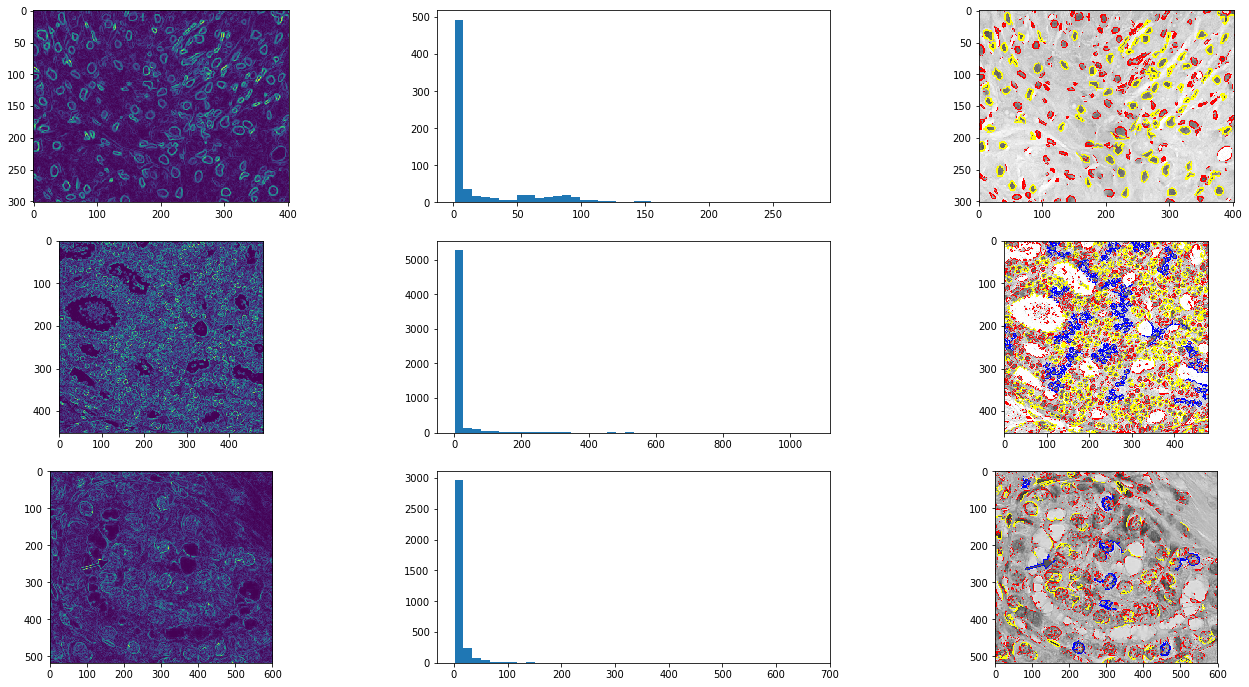

Mean error: 31.0%


In [17]:
image_processing_algorithm()

Image #1: CellsHE1.jpg
Found 175 small blobs
Found 127 medium blobs
Found 5 big blobs
Estimated number of cells: 138
Error: 38.0%

Image #2: CellsHE2.jpg
Found 1086 small blobs
Found 268 medium blobs
Found 50 big blobs
Estimated number of cells: 449
Error: 0.2%

Image #3: CellsHE3.jpg
Found 1561 small blobs
Found 121 medium blobs
Found 28 big blobs
Estimated number of cells: 210
Error: 40.0%



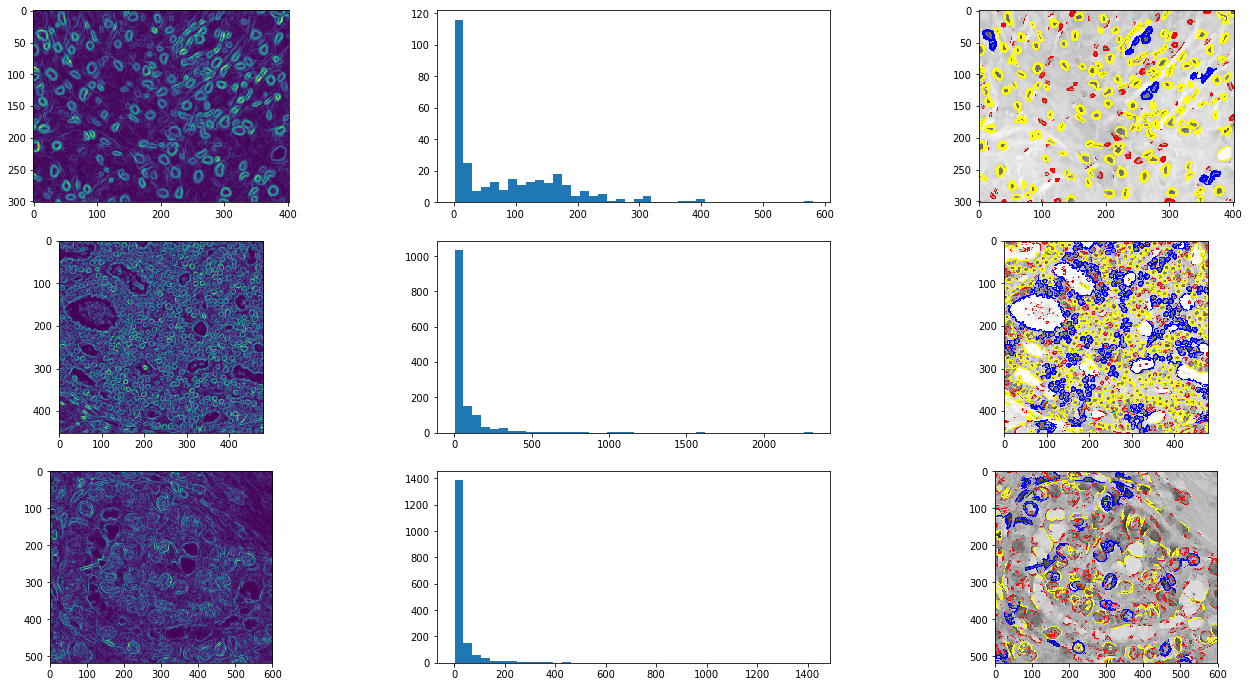

Mean error: 26.1%


In [18]:
image_processing_algorithm(filter_mode="Gaussian")

Image #1: CellsHE1.jpg
Found 686 small blobs
Found 90 medium blobs
Found 1 big blobs
Estimated number of cells: 93
Error: 7.0%

Image #2: CellsHE2.jpg
Found 3451 small blobs
Found 185 medium blobs
Found 43 big blobs
Estimated number of cells: 431
Error: 4.2%

Image #3: CellsHE3.jpg
Found 3291 small blobs
Found 83 medium blobs
Found 23 big blobs
Estimated number of cells: 158
Error: 5.3%



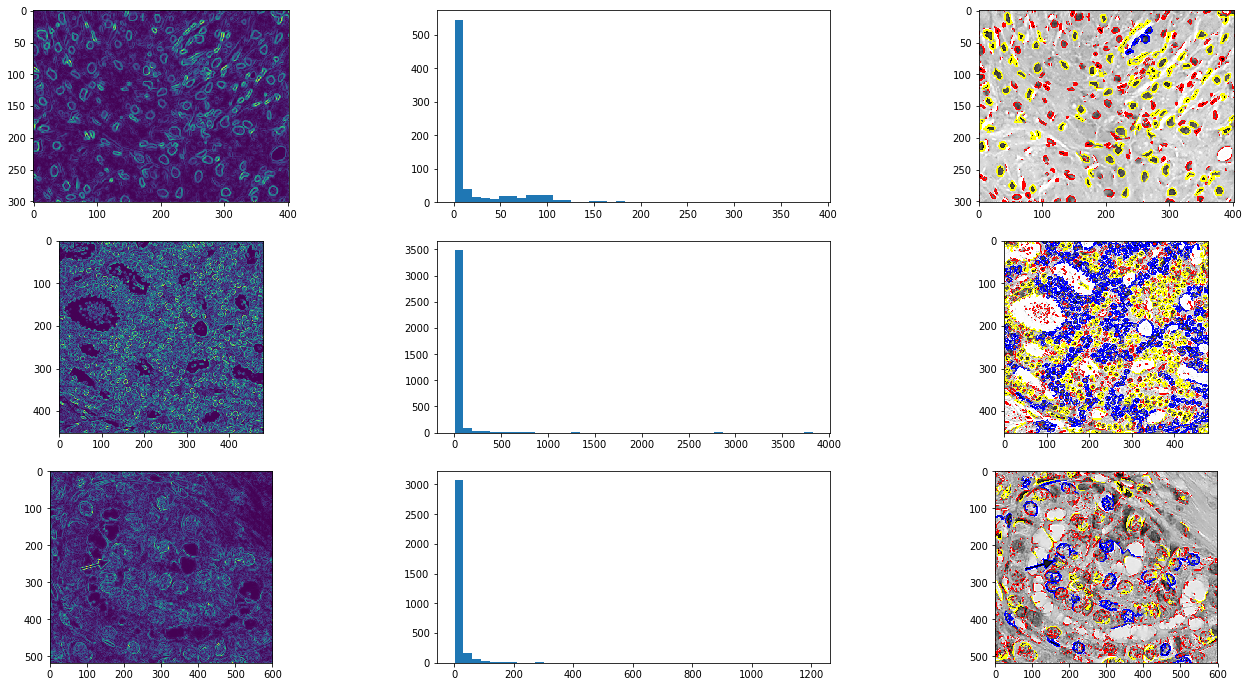

Mean error: 5.5%


In [19]:
image_processing_algorithm(filter_mode="Custom")